In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from lightgbm import LGBMRegressor
from datetime import timedelta
import statistics
from collections import Counter

In [2]:
class Trade_Broker():
    def __init__(self, strategy_name, price_history, *args):
        self.strategy_name = strategy_name
        self.price_history = price_history
        self.args = args

        self.current_step = 0
        self.current_price = self.price_history.iloc[self.current_step].prices
        self.current_datetime = self.price_history.iloc[self.current_step].time

        self.capacity_in_use = 0
        self.profit = 0
        self.total_capacity = 100
        self.power = 100
        self.hours_per_time_step = 0.5
        self.round_trip_efficiency = 0.85
        self.trade_history = []
        self.portfolio_history = []

    def time_step(self, n_steps = 1):
        """Step time forward. This function increases the Trade_Broker's 
        'current_step' value.

        Inputs:
        - n_steps: number of steps to move forward, default: 1
        """
        try:
            self.current_step = self.current_step + n_steps
            self.current_price = self.price_history.iloc[self.current_step].prices
            self.current_datetime = self.price_history.iloc[self.current_step].time
        except Exception as e:
            print(e)

        #update portfolio history
        record = {'timestamp' : self.current_datetime,
                  'profit_to_date': self.profit,
                  'capacity': self.capacity_in_use, 
                  'price': self.current_price}
        self.portfolio_history.append(record)

    def buy(self, buy_amount):
        """Simulate buying energy at the current time step at the current_price.
        Method checks if a) the price is nan and b) if there is not enough free 
        capacity to make the trade. If either case is true, the buy order is 
        cancelled.

        Inputs:
        - buy_amount: amount of energy to buy in kWh

        """
        #check if price is nan
        if math.isnan(self.current_price):
            warnings.warn("Price is nan, buy order cancelled.")
            return
        #check if buying is possible:
        free_capacity = self.total_capacity - self.capacity_in_use
        max_buy_amount = self.hours_per_time_step*self.power
        if free_capacity < buy_amount:
            warnings.warn("Tried to buy but did not have free capacity, buy order cancelled.")
            return
        elif buy_amount > max_buy_amount:
            warnings.warn("Tried to buy more than permitted by, resorting to max possible amount.")
            buy_amount = max_buy_amount
        
        self.capacity_in_use = self.capacity_in_use + buy_amount
        self.profit = self.profit - self.current_price*buy_amount

        #record exchange
        record = {'Trade' : 'Buy',
                  'Amount' : buy_amount,
                  'timestamp' : self.current_datetime,
                  'profit_to_date': self.profit,
                  'capacity': self.capacity_in_use}
        self.trade_history.append(record)

    def sell(self, sell_amount):
        """Simulate selling energy at the current time step at the current_price.
        Method checks if a) the price is nan and b) if there is not enough capacity
        to make the trade. If either case is true, the sell order is cancelled.

        Inputs:
        - sell_amount: amount of energy to sell in kWh

        """
        #check if price is nan
        if math.isnan(self.current_price):
            warnings.warn("price is nan, sell order cancelled.")
            return
        #check if selling is possible:
        max_sell_amount = self.hours_per_time_step*self.power
        if self.capacity_in_use < sell_amount:
            warnings.warn("Tried to sell but did not have enough capacity, sell order cancelled")
            return
        elif sell_amount > max_sell_amount:
            warnings.warn("Tried to sell more than permitted by, resorting to max possible amount.")
            sell_amount = max_sell_amount
        
        self.capacity_in_use = self.capacity_in_use - sell_amount
        self.profit = self.profit + self.current_price*sell_amount*self.round_trip_efficiency

        #record exchange
        record = {'Trade' : 'Sell',
                  'Amount' : sell_amount,
                  'timestamp' : self.current_datetime,
                  'profit_to_date': self.profit,
                  'capacity': self.capacity_in_use}
        self.trade_history.append(record)

In [3]:
def random_strategy(price_history_df):
    """Basic trading strategy where everyday, a buy order and sell order 
    are made at random times.

    Inputs:
    - price_history_df: data containing historical prices,
    
    """
    number_of_time_steps = len(price_history_df)
    model = Trade_Broker('basic_strategy', price_history_df)

    for t in range(number_of_time_steps):
        buy_hour = np.random.randint(0, 24)
        sell_hour = np.random.randint(0, 24)

        if t % (48*365) == 0:
            print(model.current_datetime)
            print(f'Profit so far: {model.profit}')
        capacity_in_use = model.capacity_in_use
        total_capacity = model.total_capacity
        power = model.power
        hours_per_time_step = model.hours_per_time_step
        capacity_per_time_step = power*hours_per_time_step
        free_capacity = total_capacity - capacity_in_use
        # hour = get_hour_from_datetime(model.current_datetime)

        able_to_buy = capacity_per_time_step <= free_capacity
        able_to_sell = capacity_per_time_step <= capacity_in_use

        hour = model.current_datetime.hour

        if hour == buy_hour and able_to_buy:
            model.buy(capacity_per_time_step)

        if hour == sell_hour and able_to_sell:
            model.sell(capacity_per_time_step)

        model.time_step()
    print(f'Total Profit: £{model.profit}')
    return model 

In [4]:
def get_hour_from_datetime(date):
    """Function to extract the float hour value from a datetime object.
    This value includes the number of minutes as a decimal.

    Inputs:
    - date: datetime object to extract hour from
    """
    hour = pd.to_datetime(date).hour
    minute = pd.to_datetime(date).minute
    minute_in_hours = minute/60
    hour = hour + minute_in_hours
    return hour

date = pd.to_datetime('2016-01-01 04:30:00')

#basic strategy
def basic_strategy(price_history_df, buy_hour, sell_hour):
    """Basic trading strategy where everyday, a buy order and sell order 
    are made a prespecified times.

    Inputs:
    - price_history_df: data containing historical prices,
    - buy_hour: hour of the day to buy energy
    - sell_hour: hour of the day to sell energy
    
    """
    number_of_time_steps = len(price_history_df)
    model = Trade_Broker('basic_strategy', price_history_df)

    for t in range(number_of_time_steps):
        if t % (48*365) == 0:
            print(model.current_datetime)
            print(f'Profit so far: £{model.profit}')
        capacity_in_use = model.capacity_in_use
        total_capacity = model.total_capacity
        power = model.power
        hours_per_time_step = model.hours_per_time_step
        capacity_per_time_step = power*hours_per_time_step
        free_capacity = total_capacity - capacity_in_use
        # hour = get_hour_from_datetime(model.current_datetime)

        able_to_buy = capacity_per_time_step <= free_capacity
        able_to_sell = capacity_per_time_step <= capacity_in_use

        hour = model.current_datetime.hour

        if hour == buy_hour and able_to_buy:
            model.buy(capacity_per_time_step)

        if hour == sell_hour and able_to_sell:
            model.sell(capacity_per_time_step)

        model.time_step()
    print(f'Total Profit: £{model.profit}')
    return model 


In [5]:
def process_data(df):
    """Feature engineering for date information. This function is designed
    to produce features to aid the ML models in forecasting. The function 
    extracts features such as day of the week, week of the year, month, etc.
    to allow the models to more easily discriminate by temporal patterns.

    Inputs:
    - df: price_history_df (from input_data.csv)

    Outputs:
    - df: modified version of price_history_df including new time-related
      columns
    """
    df = pd.read_csv('input_data.csv')
    df['time'] = pd.to_datetime(df['time'])
    df.drop_duplicates(subset='time', inplace=True)
    df.dropna(subset = 'time', inplace = True)
    df.loc[df['prices'] == 9999, 'prices'] = np.nan
    df.set_index('time', inplace = True)
    df['time'] = df.index

    # df['year'] = pd.DatetimeIndex(df.index).year
    df[['year', 'week', 'day']] = df.index.isocalendar().astype('float')
    df['date'] = df.index.strftime('%Y-%m-%d')
    df['month'] = pd.DatetimeIndex(df.index).month
    # df['week'] = pd.DatetimeIndex(df.index).week
    # df['day'] = pd.DatetimeIndex(df.index).day
    df['weekday'] = pd.DatetimeIndex(df.index).dayofweek
    df['weekend'] = df['weekday'] > 4
    df['hour'] = pd.DatetimeIndex(df.index).hour
    df['minute'] = pd.DatetimeIndex(df.index).minute
    df['minutes_in_hour'] = df['minute']/60
    df['float_hour'] = df['hour'] + df['minutes_in_hour']
    df['business_hour'] = (df['float_hour'] >= 8)*(df['float_hour'] <= 19)*(df['weekend'] == True)
    # df['last_year'] = df['prices'].shift(periods=1, freq='y')
    # y_df = df.copy
    # for i in range(24):
    #     df[f'price_shift_{i}'] = df['prices'].shift(periods=-i, freq='h')

    #bank holidays
    # try:
    #     path = 'https://www.gov.uk/bank-holidays.json' #'holidays.json' 
    #     bank_holidays = pd.read_json(path_or_buf = path)
    #     bank_holidays = pd.json_normalize(bank_holidays.to_dict())
    #     englandandwales_holidays = pd.DataFrame(bank_holidays['england-and-wales.events'].iloc[0])
    #     return englandandwales_holidays

    # except Exception as e:
    #     print(f'Unable to read holiday json from {path}')
    #     print(e)
    return df

def process_daily_data(df):
    """Data is aggregated by day. This is done to allow an ML model to predict 
    the hour of maximum price and minimum price for any given day.
    """
    daily_df = df.groupby(['date']).agg('mean')
    daily_df.drop(columns = ['hour', 'float_hour', 'minute', 'minutes_in_hour', 'business_hour'], inplace = True)

    max_hours = []
    min_hours = []

    for day, day_df in df.groupby(['date']):
        try:
            max_hour = day_df['hour'][day_df['prices'].idxmax()]
            min_hour = day_df['hour'][day_df['prices'].idxmin()]
        except:
            max_hour = np.nan
            min_hour = np.nan
        
        max_hours.append(max_hour)
        min_hours.append(min_hour)

    daily_df['max_hour'] = max_hours
    daily_df['min_hour'] = min_hours

    for i in range(7):
        #give a feature for the max and min price from the last 7 days
        daily_df[f'max_hour_{i}_days_ago'] = daily_df['max_hour'].shift(periods = i)
        daily_df[f'min_hour_{i}_days_ago'] = daily_df['min_hour'].shift(periods = i)

    #shift average price data back a day - this ensures the model doesn't1
    #have before-the-fact price information/data leakage.
    daily_df['prices'] = daily_df['prices'].shift(periods = 1)
    daily_df['prices'].fillna(method = 'backfill', inplace=True)

    return daily_df

In [6]:
def train_ml_models(data, current_date, training_data_start_date = '1990-01-01'):
    """Function to train ML models. This function trains two simple LGBMRegressor
    models to determine at the beginning of each day which hours that day will
    have the highest and lowest energy price.

    Inputs:
    - data: Training data, outputted from process_daily_data().
    - current_date: date that the model is being simulated.
    - training_data_start_date: date that the ML train data should begin from
        default: '1990-01-01' i.e. use all available data.
    """
    train_data = data[data.index < current_date]
    train_data = train_data[train_data.index > training_data_start_date]
    y_train_max = train_data['max_hour']
    y_train_min = train_data['min_hour']
    X_train = train_data.drop(columns = ['max_hour', 'min_hour'])

    max_predictor = LGBMRegressor()
    min_predictor = LGBMRegressor()

    if len(X_train) > 5:
        valid = True
        max_predictor.fit(X_train, y_train_max)
        min_predictor.fit(X_train, y_train_min)
    else:
        valid = False
        max_predictor = min_predictor = -1


    today_vector = data[data.index == current_date].drop(columns = ['max_hour', 'min_hour'])

    return max_predictor, min_predictor, today_vector, valid

# train_ml_models(ddf, current_date = '2023-01-01')

In [7]:
def daily_ml_strategy(price_history_df, daily_df, training_data_days = 9999):
    """Trade based on the output of the ML models. 2 ML models are used to 
    determine which hour of each day will have the highest and lowest price
    respectively. 

    Inputs:
    - price_history_df: data containing historical prices,
    - daily_df: daily aggregated data for use in model training.
    - training_data_days: number of days before current date that should be 
        considered in training data.
    """
    number_of_time_steps = len(price_history_df)
    model = Trade_Broker('daily_ml_strategy', price_history_df)

    #initialize predictors
    current_date = model.current_datetime.strftime('%Y-%m-%d')
    max_predictor, min_predictor, today_vector, valid = train_ml_models(daily_df, current_date)

    for t in range(number_of_time_steps):
        if t % (48*365) == 0:
            print(model.current_datetime)
            print(f'Profit so far: £{model.profit}')
        capacity_in_use = model.capacity_in_use
        total_capacity = model.total_capacity
        power = model.power
        hours_per_time_step = model.hours_per_time_step
        capacity_per_time_step = power*hours_per_time_step
        free_capacity = total_capacity - capacity_in_use
        # hour = get_hour_from_datetime(model.current_datetime)

        able_to_buy = capacity_per_time_step <= free_capacity
        able_to_sell = capacity_per_time_step <= capacity_in_use

        hour = model.current_datetime.hour
        day = model.current_datetime.day
        month = model.current_datetime.month
        current_date = model.current_datetime.strftime('%Y-%m-%d')
        if day == 1 and (month == 1 or month == 7):
            #retrain models every 6 months
            train_data_start_date = str(pd.to_datetime(current_date) - timedelta(days = training_data_days))
            max_predictor, min_predictor, today_vector, valid = train_ml_models(daily_df, current_date, train_data_start_date)
        if hour == 0:
            #rerun_models each day
            if valid:
                sell_hour = int(max_predictor.predict(today_vector))
                buy_hour = int(min_predictor.predict(today_vector))
            else:
                sell_hour = buy_hour = -1

        if hour == buy_hour and able_to_buy:
            model.buy(capacity_per_time_step)

        if hour == sell_hour and able_to_sell:
            model.sell(capacity_per_time_step)

        model.time_step()
    print(f'Total Profit: £{model.profit}')
    return model

In [8]:
def get_min_max_hours(price_history_df, date, start_date, agg_metric):
    """For each day is the historic dataset, the hours with the highest and
    lowest price is identified.

    Inputs:
    - price_history_df: Historic price data
    - date: current simulation date
    - start_date: lower bound of dates to be analysed
    - agg_metric: metric to use when aggregating by hour of the day

    Returns:
    - max_hour: Hour which historically has the highest price
    - min_hour: Hour which historically has the lowest price

    """
    past_data = price_history_df[price_history_df['time'] < date]
    past_data = past_data[past_data['time'] >= start_date]
    past_data_hours = past_data.groupby('hour').agg(agg_metric).reset_index()
    max_hour = past_data_hours['hour'][past_data_hours['prices'].idxmax()]
    min_hour = past_data_hours['hour'][past_data_hours['prices'].idxmin()]

    return max_hour, min_hour


#historic_min_max_hour strategy
def historic_min_max_hour_strategy(price_history_df, training_data_days = 9999, agg_metric = 'mean'):
    """Trading strategy based on buying during the historically lowest 
    priced hour and buying during the historically highest priced hour.

    Inputs:
    - price_history_df: Historic price data
    - training_data_days: How many days before current date to look at 
        when analysing historic prices, default: 9999 (i.e. use all data)
    - agg_metric: metric to use when aggregating by hour of the day
    """
    number_of_time_steps = len(price_history_df)
    model = Trade_Broker('basic_strategy', price_history_df)
    #initialise
    sell_hour = buy_hour = -1 
    #set to -1 so model will not buy or sell until values are updated

    for t in range(number_of_time_steps):
        date = model.current_datetime

        if date.day == 28:
            #end of every month recalculate
            start_date = str(pd.to_datetime(date) - timedelta(days = training_data_days))
            sell_hour, buy_hour = get_min_max_hours(price_history_df, date, start_date, agg_metric)

        if t % (48*365) == 0:
            #readouts
            print(date)
            print(model.profit)
        capacity_in_use = model.capacity_in_use
        total_capacity = model.total_capacity
        power = model.power
        hours_per_time_step = model.hours_per_time_step
        capacity_per_time_step = power*hours_per_time_step
        free_capacity = total_capacity - capacity_in_use
        # hour = get_hour_from_datetime(model.current_datetime)

        able_to_buy = capacity_per_time_step <= free_capacity
        able_to_sell = capacity_per_time_step <= capacity_in_use

        hour = model.current_datetime.hour

        #trade if possible
        if hour == buy_hour and able_to_buy:
            model.buy(capacity_per_time_step)

        if hour == sell_hour and able_to_sell:
            model.sell(capacity_per_time_step)

        model.time_step()
    print(f'Total Profit: £{model.profit}')
    return model    

In [9]:
#prep data
price_history_df = pd.read_csv('input_data.csv')
price_history_df = process_data(price_history_df)
daily_df = process_daily_data(price_history_df)

2016-01-01 00:00:00
Profit so far: 0
2017-01-30 00:00:00
Profit so far: -115072.37499999999
2018-01-30 00:00:00
Profit so far: -246775.74450000012


C:\Users\PhilipComrie-Smith\AppData\Local\Temp\ipykernel_10412\3025293059.py:53: UserWarning: Price is nan, buy order cancelled.
  warnings.warn("Price is nan, buy order cancelled.")


2019-01-30 00:30:00
Profit so far: -476671.3538
2020-01-30 00:30:00
Profit so far: -650986.8011749998
2021-03-21 16:30:00
Profit so far: -827130.1976750012
2022-03-21 16:30:00
Profit so far: -1270742.6608000011
2023-03-21 16:30:00
Profit so far: -1971093.935800002
single positional indexer is out-of-bounds
Total Profit: £-2018390.6358000014
2016-01-01 00:00:00
Profit so far: £0
2017-01-30 00:00:00
Profit so far: £-222124.231725
2018-01-30 00:00:00
Profit so far: £-472074.17952500016


C:\Users\PhilipComrie-Smith\AppData\Local\Temp\ipykernel_10412\3025293059.py:87: UserWarning: price is nan, sell order cancelled.
  warnings.warn("price is nan, sell order cancelled.")


2019-01-30 00:30:00
Profit so far: £-452458.9563750004
2020-01-30 00:30:00
Profit so far: £-304874.36635000043
2021-03-21 16:30:00
Profit so far: £458178.36157499976
2022-03-21 16:30:00
Profit so far: £2621658.066325002
2023-03-21 16:30:00
Profit so far: £4234468.057075006
single positional indexer is out-of-bounds
Total Profit: £4285119.232075011
2016-01-01 00:00:00
Profit so far: £0
2017-01-30 00:00:00
Profit so far: £468741.85080000036
2018-01-30 00:00:00
Profit so far: £341876.83897500107


C:\Users\PhilipComrie-Smith\AppData\Local\Temp\ipykernel_10412\3025293059.py:87: UserWarning: price is nan, sell order cancelled.
  warnings.warn("price is nan, sell order cancelled.")


2019-01-30 00:30:00
Profit so far: £-60318.01037499914
2020-01-30 00:30:00
Profit so far: £-368725.96727499895
2021-03-21 16:30:00
Profit so far: £-746146.6415999981
2022-03-21 16:30:00
Profit so far: £-2379304.0166
2023-03-21 16:30:00
Profit so far: £-3984446.8064499996
single positional indexer is out-of-bounds
Total Profit: £-4026400.006449999


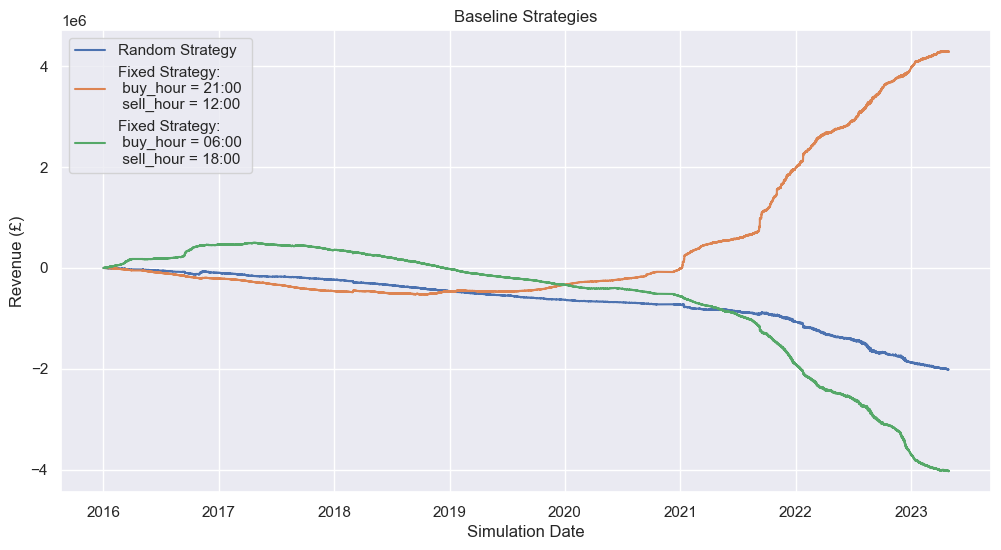

In [10]:
#basic strategies
sns.set()
fig, ax = plt.subplots(figsize = (12, 6))
ax.set_title('Baseline Strategies')
ax.set_ylabel('Revenue (£)')
ax.set_xlabel('Simulation Date')

model = random_strategy(price_history_df)
record_random = pd.DataFrame.from_records(model.trade_history)
ax.plot(record_random['timestamp'], record_random['profit_to_date'], label = 'Random Strategy')

buy_hour = 21
sell_hour = 12
model = basic_strategy(price_history_df, buy_hour, sell_hour)   

record_basic1 = pd.DataFrame.from_records(model.trade_history)
ax.plot(record_basic1['timestamp'], record_basic1['profit_to_date'], label = 'Fixed Strategy: \n buy_hour = 21:00 \n sell_hour = 12:00')

buy_hour = 6
sell_hour = 18
model = basic_strategy(price_history_df, buy_hour, sell_hour)   

record_basic2 = pd.DataFrame.from_records(model.trade_history)
ax.plot(record_basic2['timestamp'], record_basic2['profit_to_date'], label = 'Fixed Strategy: \n buy_hour = 06:00 \n sell_hour = 18:00')

ax.legend()

2016-01-01 00:00:00
Profit so far: £0
2017-01-30 00:00:00
Profit so far: £203421.95000000024
2018-01-30 00:00:00
Profit so far: £191837.2578750002


C:\Users\PhilipComrie-Smith\AppData\Local\Temp\ipykernel_10412\3025293059.py:87: UserWarning: price is nan, sell order cancelled.
  warnings.warn("price is nan, sell order cancelled.")


2019-01-30 00:30:00
Profit so far: £467052.94852500013
2020-01-30 00:30:00
Profit so far: £803482.2515499998
2021-03-21 16:30:00
Profit so far: £1139077.2670499985
2022-03-21 16:30:00
Profit so far: £296445.73812499834
2023-03-21 16:30:00
Profit so far: £622732.8626749974
single positional indexer is out-of-bounds
Total Profit: £616695.3376749974
2016-01-01 00:00:00
Profit so far: £0
2017-01-30 00:00:00
Profit so far: £203421.95000000024
2018-01-30 00:00:00
Profit so far: £194173.78362500036


C:\Users\PhilipComrie-Smith\AppData\Local\Temp\ipykernel_10412\3025293059.py:87: UserWarning: price is nan, sell order cancelled.
  warnings.warn("price is nan, sell order cancelled.")


2019-01-30 00:30:00
Profit so far: £559209.6992750003
2020-01-30 00:30:00
Profit so far: £784654.0509000018
2021-03-21 16:30:00
Profit so far: £1130570.0814000005
2022-03-21 16:30:00
Profit so far: £892641.0469750008
2023-03-21 16:30:00
Profit so far: £1115903.6715250004
single positional indexer is out-of-bounds
Total Profit: £1078206.6465249988
2016-01-01 00:00:00
Profit so far: £0
2017-01-30 00:00:00
Profit so far: £216881.45000000024
2018-01-30 00:00:00
Profit so far: £217643.46487500018


C:\Users\PhilipComrie-Smith\AppData\Local\Temp\ipykernel_10412\3025293059.py:87: UserWarning: price is nan, sell order cancelled.
  warnings.warn("price is nan, sell order cancelled.")


2019-01-30 00:30:00
Profit so far: £482656.605525
2020-01-30 00:30:00
Profit so far: £787153.8496500013
2021-03-21 16:30:00
Profit so far: £1447776.076150001
2022-03-21 16:30:00
Profit so far: £1260507.9559000016
2023-03-21 16:30:00
Profit so far: £1626398.0804499998
single positional indexer is out-of-bounds
Total Profit: £1588701.0554499982


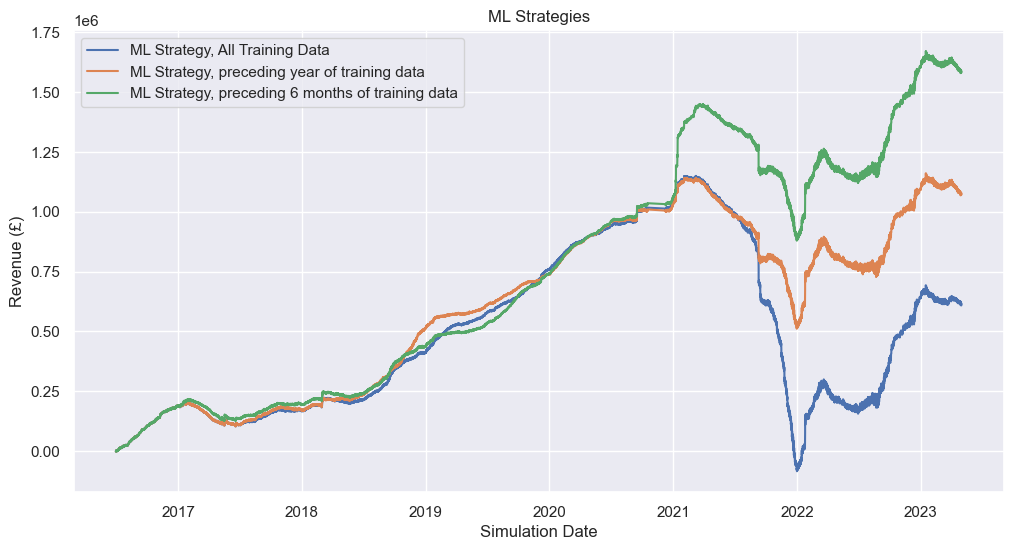

In [11]:
#Run ML strategies
sns.set()
fig, ax = plt.subplots(figsize = (12, 6))
ax.set_title('ML Strategies')
ax.set_ylabel('Revenue (£)')
ax.set_xlabel('Simulation Date')

daily_ml_strategy_model = daily_ml_strategy(price_history_df, daily_df)
record_ml1 = pd.DataFrame.from_records(daily_ml_strategy_model.trade_history)
ax.plot(record_ml1['timestamp'], record_ml1['profit_to_date'], label = 'ML Strategy, All Training Data')

daily_ml_strategy_model2 = daily_ml_strategy(price_history_df, daily_df, 365)
record_ml2 = pd.DataFrame.from_records(daily_ml_strategy_model2.trade_history)
ax.plot(record_ml2['timestamp'], record_ml2['profit_to_date'], label = 'ML Strategy, preceding year of training data')

daily_ml_strategy_model3 = daily_ml_strategy(price_history_df, daily_df, 30*6)
record_ml3 = pd.DataFrame.from_records(daily_ml_strategy_model3.trade_history)
ax.plot(record_ml3['timestamp'], record_ml3['profit_to_date'], label = 'ML Strategy, preceding 6 months of training data')

portfolio_hist = pd.DataFrame.from_records(daily_ml_strategy_model3.portfolio_history)

portfolio_hist.to_csv('portfolio_history.csv')

ax.legend()

2016-01-01 00:00:00
0
2017-01-30 00:00:00
722179.2257999993
2018-01-30 00:00:00
1174738.118299999


C:\Users\PhilipComrie-Smith\AppData\Local\Temp\ipykernel_10412\3025293059.py:87: UserWarning: price is nan, sell order cancelled.
  warnings.warn("price is nan, sell order cancelled.")


2019-01-30 00:30:00
1482130.1825499989
2020-01-30 00:30:00
1687075.3678249975
2021-03-21 16:30:00
1864760.4007499986
2022-03-21 16:30:00
2605051.9675000003
2023-03-21 16:30:00
3884892.45825
single positional indexer is out-of-bounds
Total Profit: £3935543.6332500004
2016-01-01 00:00:00
0
2017-01-30 00:00:00
721455.5757999992
2018-01-30 00:00:00
1156109.648299998


C:\Users\PhilipComrie-Smith\AppData\Local\Temp\ipykernel_10412\3025293059.py:87: UserWarning: price is nan, sell order cancelled.
  warnings.warn("price is nan, sell order cancelled.")


2019-01-30 00:30:00
1634387.9589749994
2020-01-30 00:30:00
2064956.7530999982
2021-03-21 16:30:00
2854711.7376999976
2022-03-21 16:30:00
4976674.442449992
2023-03-21 16:30:00
6940606.016999988
single positional indexer is out-of-bounds
Total Profit: £7029764.8669999875
2016-01-01 00:00:00
0
2017-01-30 00:00:00
782922.2507999992
2018-01-30 00:00:00
1277374.137499999


C:\Users\PhilipComrie-Smith\AppData\Local\Temp\ipykernel_10412\3025293059.py:87: UserWarning: price is nan, sell order cancelled.
  warnings.warn("price is nan, sell order cancelled.")


2019-01-30 00:30:00
1781271.1320000004
2020-01-30 00:30:00
2206116.521125
2021-03-21 16:30:00
2974629.9807250006
2022-03-21 16:30:00
5043841.228725002
2023-03-21 16:30:00
6900240.879649997
single positional indexer is out-of-bounds
Total Profit: £6984202.404650001


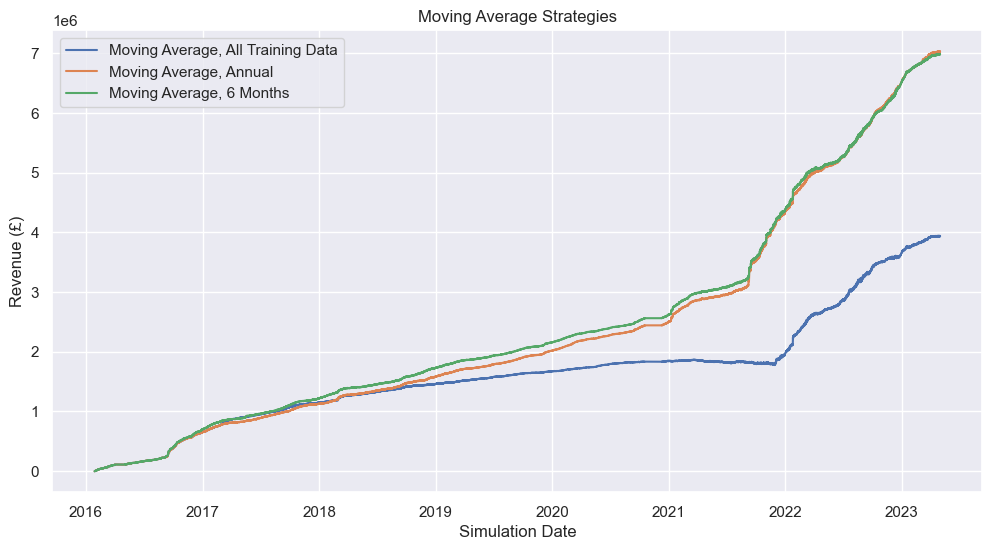

In [12]:
#Run moving average strategies
sns.set()
fig, ax = plt.subplots(figsize = (12, 6))
ax.set_title('Moving Average Strategies')
ax.set_ylabel('Revenue (£)')
ax.set_xlabel('Simulation Date')

ma_model1 = historic_min_max_hour_strategy(price_history_df)
ma_record1 = pd.DataFrame.from_records(ma_model1.trade_history)
ax.plot(ma_record1['timestamp'], ma_record1['profit_to_date'], label = 'Moving Average, All Training Data')

ma_model2 = historic_min_max_hour_strategy(price_history_df, 365)
ma_record2 = pd.DataFrame.from_records(ma_model2.trade_history)
ax.plot(ma_record2['timestamp'], ma_record2['profit_to_date'], label = 'Moving Average, Annual')

ma_model3 = historic_min_max_hour_strategy(price_history_df, 30*6)
ma_record3 = pd.DataFrame.from_records(ma_model3.trade_history)
ax.plot(ma_record3['timestamp'], ma_record3['profit_to_date'], label = 'Moving Average, 6 Months')

ax.legend()

In [13]:
portfolio_hist = pd.DataFrame.from_records(ma_model3.portfolio_history)

ma_model3.portfolio_history

portfolio_hist.to_csv('portfolio_history.csv')

2016-01-01 00:00:00
0
2017-01-30 00:00:00
686834.5257999992
2018-01-30 00:00:00
1139393.4182999993


C:\Users\PhilipComrie-Smith\AppData\Local\Temp\ipykernel_10412\3025293059.py:87: UserWarning: price is nan, sell order cancelled.
  warnings.warn("price is nan, sell order cancelled.")


2019-01-30 00:30:00
1422005.2576750012
2020-01-30 00:30:00
1642347.7854499996
2021-03-21 16:30:00
1843607.3183750007
2022-03-21 16:30:00
1572972.1855000006
2023-03-21 16:30:00
158764.67664999972
single positional indexer is out-of-bounds
Total Profit: £21483.93304999969
2016-01-01 00:00:00
0
2017-01-30 00:00:00
686834.5257999992
2018-01-30 00:00:00
1186974.942799999


C:\Users\PhilipComrie-Smith\AppData\Local\Temp\ipykernel_10412\3025293059.py:87: UserWarning: price is nan, sell order cancelled.
  warnings.warn("price is nan, sell order cancelled.")


2019-01-30 00:30:00
1678761.08205
2020-01-30 00:30:00
2112104.6511749984
2021-03-21 16:30:00
2910231.7372749955
2022-03-21 16:30:00
4888501.962424988
2023-03-21 16:30:00
6555421.278174981
single positional indexer is out-of-bounds
Total Profit: £6612380.62817498
2016-01-01 00:00:00
0
2017-01-30 00:00:00
887891.7507999997
2018-01-30 00:00:00
1433271.0396249997


C:\Users\PhilipComrie-Smith\AppData\Local\Temp\ipykernel_10412\3025293059.py:87: UserWarning: price is nan, sell order cancelled.
  warnings.warn("price is nan, sell order cancelled.")


2019-01-30 00:30:00
1941771.9224750015
2020-01-30 00:30:00
2363257.7365999976
2021-03-21 16:30:00
3102390.822699996
2022-03-21 16:30:00
4875431.072849993
2023-03-21 16:30:00
6583390.863599988
single positional indexer is out-of-bounds
Total Profit: £6672892.688599988


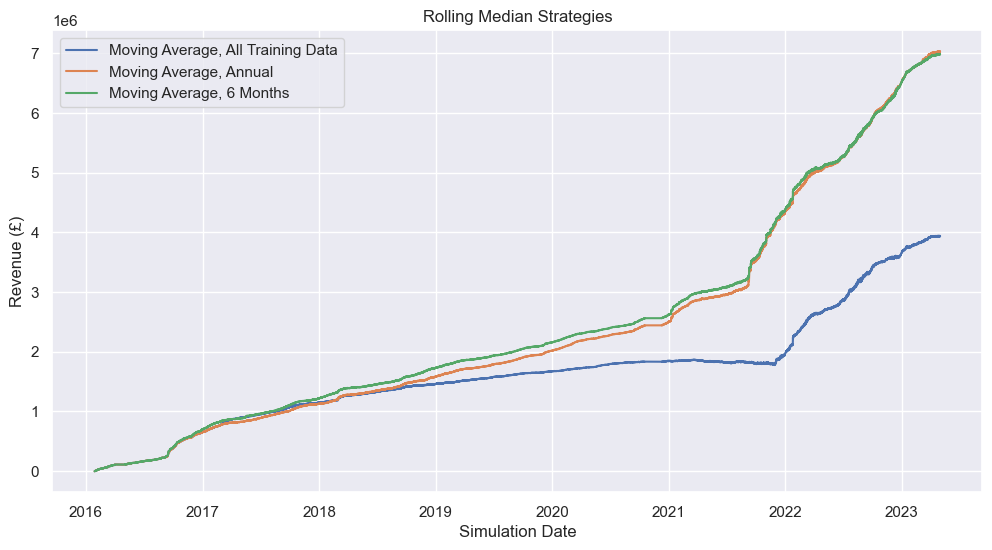

In [14]:
#Run rolling Median strategies
sns.set()
fig, ax = plt.subplots(figsize = (12, 6))
ax.set_title('Rolling Median Strategies')
ax.set_ylabel('Revenue (£)')
ax.set_xlabel('Simulation Date')

#mode = lambda srs: Counter(list(srs)).most_common(1)[0][0]

rm_model1 = historic_min_max_hour_strategy(price_history_df, agg_metric = 'median')
rm_record1 = pd.DataFrame.from_records(ma_model1.trade_history)
ax.plot(rm_record1['timestamp'], rm_record1['profit_to_date'], label = 'Moving Average, All Training Data')

rm_model2 = historic_min_max_hour_strategy(price_history_df, 365, agg_metric = 'median')
rm_record2 = pd.DataFrame.from_records(ma_model2.trade_history)
ax.plot(rm_record2['timestamp'], rm_record2['profit_to_date'], label = 'Moving Average, Annual')

rm_model3 = historic_min_max_hour_strategy(price_history_df, 30*6, agg_metric = 'median')
rm_record3 = pd.DataFrame.from_records(ma_model3.trade_history)
ax.plot(rm_record3['timestamp'], rm_record3['profit_to_date'], label = 'Moving Average, 6 Months')

ax.legend()